# Modeling True Positive and True Negative rates

We want to use the Bivariate Beta distribution built in the previous
sections. Before integrating it to the whole model, we consider a model for
sensibility and sensitivity as follows: 

Let $Y_p$ denote the number of positives tests in $n_{pos}$ individuals who
were exposed to a disease, and $Y_n$ denote the number of negative tests in
$n_{neg}$ not exposed. The person is tested with a gold standard, which is the
best benchmark and the most accurate possible.

Remind that the sensitivity $\gamma_s$ is the probability of a test being positive given
the exposition, while the specificity $\gamma_e$ is the probability of a
negative test given the non-exposition. 
Therefore, 

\begin{align*}
    Y_p &\sim Binomial(n_{pos}, \gamma_s) \\
    Y_n &\sim Binomial(n_{neg}, \gamma_e) \\
    \gamma_s &= U_1 + U_2 \\
    \gamma_e &= U_1 + U_3, 
\end{align*}

such that $(U_1, U_2, U_3, U_4) \sim Dirichlet(\alpha_1, \alpha_2, \alpha_3, \alpha_4)$. 
Besides that, there are two different models to handle with
$\alpha = (\alpha_1, \dots, \alpha_4)$. 

I. $\alpha_i \sim \operatorname{Gamma}(a^i, b^i)$, with $a^i$ and $b^i$ fixed. 

II. $\alpha_i \sim \operatorname{Dirac}(\hat{\alpha}_i)$ such that $\hat{\alpha}_i$
is calculated as explained before. 

In [1]:
import numpy as np
import pystan as ps

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set()

%matplotlib inline

import pickle

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha, BivariateBeta

## Model 

First we code the model in Stan and use PyStan as a Python interface. 

In [2]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/sensitivity_specificity/spec_sens_model_constant_alpha.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/sensitivity_specificity/spec_sens_model_constant_alpha.stan')
    with open('../models/sensitivity_specificity/spec_sens_model_constant_alpha.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data and parameter blocks

Observe that we have a boolean variable to distinguish both models. 

In [3]:
structure = sm.model_code.split('}')
print(structure[0] + '}' + structure[1]+'}' + structure[2]+'}') 

data {
    int<lower = 0> n_pos;
    int<lower = 0> n_neg; 
    int Y_p;
    int Y_n;
    vector<lower = 0>[4] alpha_data;
}
parameters {
    simplex[4] U; 
}
transformed parameters{ 
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec; 
    sens = U[1] + U[2];
    spec = U[1] + U[3];
}


### Model block 

In [4]:
print(structure[3] + '}') 


model {
    U ~ dirichlet(alpha_data);
    Y_p ~ binomial(n_pos, sens);
    Y_n ~ binomial(n_neg, spec);
}


## Toy example 

First we need to test the model with fake data. This is done to verify how the it behaves in a controlled space. 

In [5]:
n_pos = 50
n_neg = 45

sens = 0.8 
spec = 0.9

Y_p = np.random.binomial(n = n_pos, p = sens)
Y_n = np.random.binomial(n = n_neg, p = spec)

m1, m2, v1, v2, rho = sens, spec, (0.05)**2, (0.05)**2, -0.3

solution = ParameterAlpha().minimizer(m1,m2,v1,v2,rho, c = [1,1,1,1])

Notice that the estimated values are below: 

In [6]:
BivariateBeta().moments_calculus(solution.x)

(0.7605622599670436,
 0.8451216472124901,
 0.0028470020826766042,
 0.00204630495469627,
 -0.2401953043476225)

In [7]:
data = {
    "n_pos": n_pos, 
    "n_neg": n_neg, 
    "Y_p": Y_p, 
    "Y_n": Y_n, 
    "alpha_data": solution.x
}

In [8]:
fit = sm.sampling(data=data, iter=5000)

In [9]:
fit

Inference for Stan model: anon_model_283154543b71871021ef1d48f344f3a6.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

              mean se_mean      sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
U[1]          0.69  8.1e-4    0.05    0.59    0.65    0.69   0.72   0.77   3207    1.0
U[2]          0.12  6.1e-4    0.03    0.07     0.1    0.12   0.14   0.19   2855    1.0
U[3]          0.19  6.5e-4    0.04    0.12    0.17    0.19   0.22   0.27   3241    1.0
U[4]        2.7e-4  2.0e-5  1.5e-3 5.6e-17 1.4e-13 5.2e-10 1.7e-6 3.1e-3   5451    1.0
sens          0.81  6.6e-4    0.04    0.73    0.78    0.81   0.83   0.88   3228    1.0
spec          0.88  6.1e-4    0.03    0.81    0.86    0.88    0.9   0.93   2850    1.0
U_prior[1]    0.61  6.1e-4    0.06    0.48    0.57    0.61   0.65   0.72  10044    1.0
U_prior[2]    0.15  4.5e-4    0.05    0.08    0.12    0.15   0.18   0.25  10248    1.0
U_prior[3]    0.24  5.2e-4 

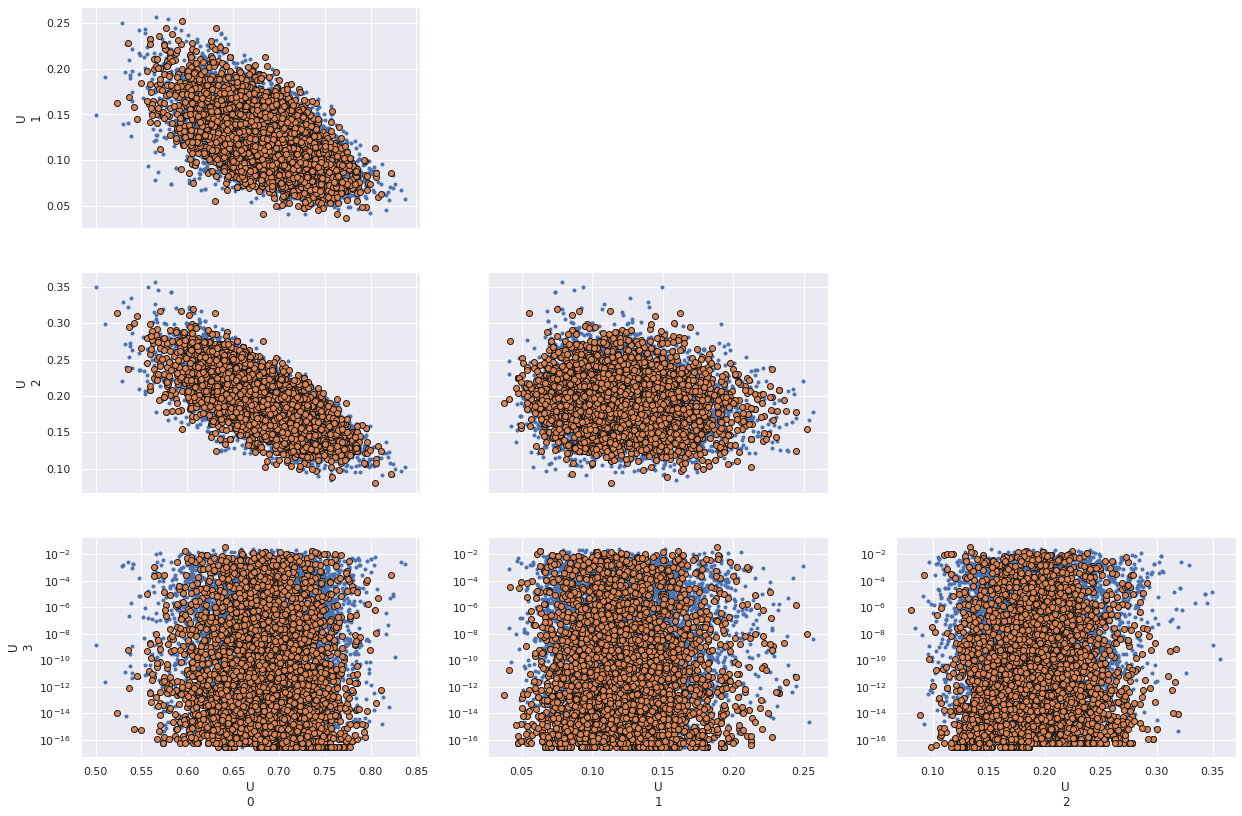

In [10]:
inference_data = az.convert_to_inference_data(fit)
ax = az.plot_pair(inference_data, var_names=('U'), divergences=True, group = 'posterior')
for i in range(3): ax[2][i].set_yscale('log')
plt.show()

Here we use a modification explained in [here]()

In [30]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.stan')
    with open('../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.pkl', 'wb') as f:
        pickle.dump(sm, f)

In [40]:
fit = sm.sampling(data=data, iter=5000, chains=4, control = {'adapt_delta': 0.8})

In [41]:
fit

Inference for Stan model: anon_model_687ec2a1287966d2c97ca899ce20f61c.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

             mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
Z[1]         0.25  6.3e-4   0.05    0.17    0.22   0.25   0.28   0.34   5104    1.0
Z[2]         0.65  1.3e-3   0.09    0.47    0.59   0.66   0.72   0.82   5456    1.0
Z[3]       2.9e-3  3.8e-4   0.02 2.2e-16 7.4e-13 4.3e-9 1.7e-5   0.03   1713    1.0
sens         0.84  5.0e-4   0.04    0.76    0.81   0.84   0.86    0.9   5413    1.0
spec         0.91  4.0e-4   0.03    0.85     0.9   0.92   0.93   0.96   5224    1.0
Z_prior[1]    0.3  6.9e-4   0.06    0.18    0.25    0.3   0.34   0.44   8926    1.0
Z_prior[2]   0.67  1.2e-3   0.12    0.42    0.59   0.67   0.75   0.87  10172    1.0
Z_prior[3] 1.8e-9  1.3e-9 1.3e-7     0.0     0.0    0.0    0.0    0.0  10010    1.0
sens_prior    0.8  5.7e-4   0.06    0.68    0.76    0.

> Why is this happening? 

Let's see what is $Z_3$! Below are the only non-zero samples!

In [27]:
samples = fit.extract()['Z_prior'][:,2]
samples = samples[samples != 0]
samples

array([9.39538726e-235, 5.54591616e-028, 6.97299981e-245, 8.55740695e-274,
       3.51662030e-163, 4.09966652e-261, 5.78625358e-018, 1.79001710e-144,
       1.10285113e-025, 5.81169612e-177, 9.86105230e-160, 2.62936048e-275,
       2.37836999e-041, 6.65118616e-028, 1.04541144e-064, 1.21295614e-206,
       1.08810872e-265, 1.41721121e-038, 1.88852663e-073, 6.22249495e-318,
       2.50058315e-156, 1.84934507e-222, 3.60819952e-232, 1.52777991e-105,
       9.38724727e-323, 1.12963499e-281, 1.61261037e-279, 4.01187817e-315,
       2.11106945e-144, 7.15423918e-152, 1.59614198e-167, 6.25478644e-223,
       6.35425623e-292, 2.91664299e-088, 2.48174334e-150, 1.72242045e-049,
       2.18637194e-265, 4.39188314e-016, 2.29847906e-087, 5.06853964e-257,
       2.48389161e-313, 2.20151458e-273, 2.84460443e-105, 2.49871185e-199,
       1.10841339e-254, 1.10316611e-221, 2.32005702e-006, 1.77144797e-205,
       1.45858886e-231, 2.60803630e-070, 4.16017842e-011, 9.91178733e-054,
       1.40367509e-009, 3

And the 0.9999-quartile is `1e-55`, that is, the probability mass is all in zero! This happens because $b \gg a$. 

In [15]:
from scipy.stats import beta as beta_dist

z_3 = beta_dist(a = solution.x[-1], b = solution.x[-2])
z_3.ppf(0.9999)

1.4222706865628329e-55

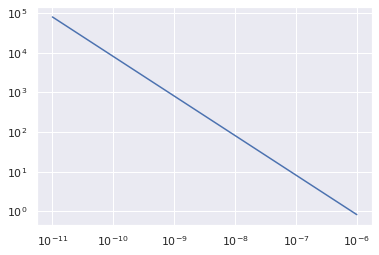

In [16]:
t = np.linspace(0,1e-6,100000)

plt.plot(t, z_3.pdf(t))
plt.xscale('log')
plt.yscale('log')

Now that we understand a bit more about the problem, let's try to change a little bit the lower bound in $\alpha_4$. 

In [17]:
alpha_hat = ParameterAlpha().mix_solver(m1,m2,v1,v2,rho, lb = 0.00001)

In [18]:
data = {
    "n_pos": n_pos, 
    "n_neg": n_neg, 
    "Y_p": Y_p, 
    "Y_n": Y_n, 
    "alpha_data": alpha_hat
}

In [19]:
fit = sm.sampling(data=data, iter=5000, pars = ('sens', 'spec', 'sens_prior', 'spec_prior'))
summary = az.summary(fit)

In [20]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sens,0.838,0.037,0.766,0.901,0.001,0.0,5304.0,5050.0,1.0
spec,0.913,0.029,0.860,0.964,0.000,0.0,4756.0,5010.0,1.0
sens_prior,0.800,0.057,0.693,0.902,0.001,0.0,9361.0,9887.0,1.0
spec_prior,0.900,0.042,0.822,0.970,0.000,0.0,10079.0,9808.0,1.0


array([[<AxesSubplot:title={'center':'spec'}>,
        <AxesSubplot:title={'center':'spec'}>],
       [<AxesSubplot:title={'center':'sens'}>,
        <AxesSubplot:title={'center':'sens'}>]], dtype=object)

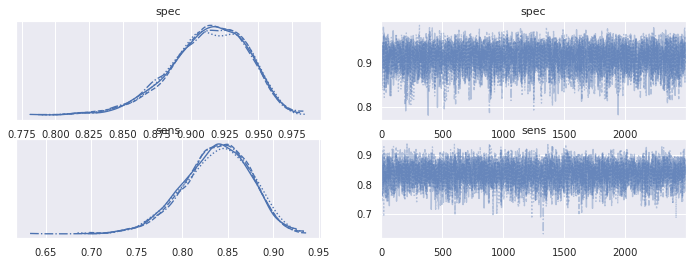

In [21]:
az.plot_trace(fit, var_names=('spec', 'sens'))

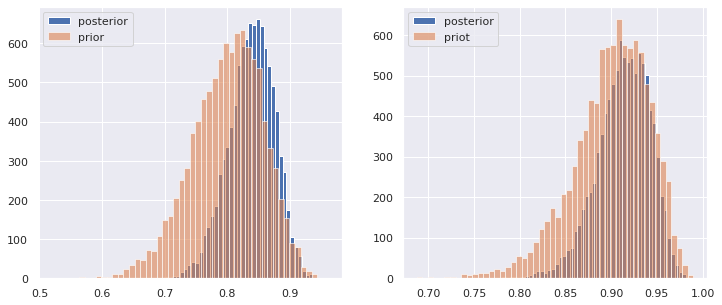

In [22]:
fig, ax = plt.subplots(1,2, figsize = (12,5))

ax[0].hist(fit.extract()['sens'], label = 'posterior', bins = 50)
ax[1].hist(fit.extract()['spec'], label = 'posterior', bins = 50)
ax[0].hist(fit.extract()['sens_prior'], label = 'prior', alpha = 0.6, bins = 50)
ax[1].hist(fit.extract()['spec_prior'], label = 'priot', alpha = 0.6, bins = 50)

ax[0].legend()
ax[1].legend()

plt.show()

Is the posterior removing some correlation?

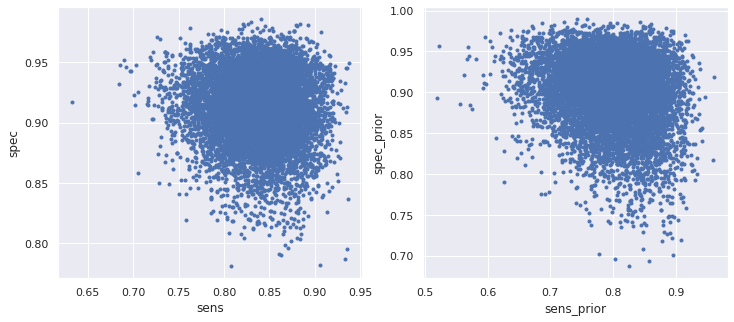

In [23]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
az.plot_pair(fit, var_names=('sens', 'spec'), ax = ax[0])
az.plot_pair(fit, var_names=('sens_prior', 'spec_prior'), ax = ax[1])
plt.show()

In [24]:
print('Prior correlation:')
print(np.corrcoef(fit.extract()['spec_prior'], fit.extract()['sens_prior'])[0,1])
print('Posterior correlation:')
print(np.corrcoef(fit.extract()['spec'], fit.extract()['sens'])[0,1])

Prior correlation:
-0.1792603583484307
Posterior correlation:
-0.07028926763969236
